In [1]:
# 集成学习(ensemble learning)库
from autogluon.tabular import TabularPredictor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# root文件读取
import uproot

In [2]:
# 定义我们所需要使用的参数（为了节约内存，不读取所有数据）
paraneed_MC_Pgamma = [
    "nch",
    "theta",
    "phi",
    "sumpf",
    "summd",
    "mr1",
    "cx",
    "cy",
    "ne",
    "age",
    "sigma",
    "inout",
    "prie",
    "pritheta",
    "priphi",
]

In [3]:
# 读取模拟数据，使用的gamma的全天模拟
gammafile = uproot.open("/home2/chenxu/data/gamma.00339651.root")
# 读取为dict，每一个value为numpy格式
gammadata = gammafile["asresult"].arrays(paraneed_MC_Pgamma, library="np")

In [4]:
gammadata

{'nch': array([12,  4, 63, ..., 17, 47,  5], dtype=int32),
 'theta': array([37.54860897, 19.84783209, 19.1456245 , ..., 45.47797878,
        42.20244325, 21.38094995]),
 'phi': array([ 98.06191472,  72.06762648,  66.64637257, ...,  24.57758235,
         23.43175948, 122.27605084]),
 'sumpf': array([ 88.50370645,  25.57250254, 391.40566493, ..., 105.65766543,
        234.10038591,  30.5587142 ]),
 'summd': array([0.        , 0.        , 0.        , ..., 5.67232191, 0.        ,
        0.        ]),
 'mr1': array([22.10997744, 27.59025884, 34.52736526, ..., 59.08148424,
        51.56098382, 23.55451592]),
 'cx': array([ -0.38184129, 120.187453  ,  13.43031409, ...,  39.20089793,
         31.16301335,  64.72047601]),
 'cy': array([-56.1544441 ,  10.9625919 ,   2.49107335, ...,  45.39713675,
         51.63047504, -36.05105944]),
 'ne': array([-1.00000000e+00, -1.00000000e+00,  2.61076242e+04, ...,
         1.47510193e+04,  3.24532296e+04, -1.00000000e+00]),
 'age': array([-1.        , -1. 

In [5]:
# 定义计算S50函数
from scipy.special import gamma
from math import pi


def getS50(ne: np.ndarray, s: np.ndarray):
    """Get S50 from NKG function.

    Input:
        ne: Ne of Event.
        s: age of Event.

    Output:
        S50
    """
    rm = 130.0
    r = 50.0
    nr = ne / (rm * rm)
    gg1 = gamma(4.5 - s)
    gg2 = 2 * pi * gamma(s) * gamma(4.5 - 2 * s)
    rr1 = pow(r / rm, s - 2)
    rr2 = pow(1 + r / rm, s - 4.5)
    return nr * gg1 / gg2 * rr1 * rr2

In [6]:
# 计算模拟数据的S50
gammadata["S50"] = getS50(gammadata["ne"], gammadata["age"])

### 初步cut
第一步的cut是为了去掉过多的宇宙线事例

$nch>=16$

$sigma<=1$

$inout==1$

$0.301<age<1.599$

$summd<0.4$ or $summd<1.2e-3*sumpf^{1.6}$

$theta<60$

In [7]:
gammadata_need_high = np.where(
    (gammadata["nch"] >= 16)
    & (gammadata["sigma"] < 1)
    & (gammadata["inout"] == 1)
    & (gammadata["age"] > 0.301)
    & (gammadata["age"] < 1.599)
    & (
        (gammadata["summd"] < 0.4)
        | (gammadata["summd"] < 1.2e-3 * gammadata["sumpf"] ** 1.6)
    )
    & (gammadata["theta"] < 60)
)

gammadata_high = {key: gammadata[key][gammadata_need_high] for key in gammadata.keys()}

In [8]:
# 因为这3个量跨度比较大，所以取对数
for para in ["ne", "S50", "sumpf", "prie"]:
    gammadata_high[para] = np.log10(gammadata_high[para])

## 能量拟合

In [13]:
# label = "prie"
gammadata_high_df = pd.DataFrame(gammadata_high)
# columns_need = [
#     "theta",
#     "sigma",
#     "cx",
#     "cy",
#     "sumpf",
#     "mr1",
#     "ne",
#     "age",
#     "S50",
# ]
# columns_need.append(label)
# predictor = TabularPredictor(
#     label=label,
#     path="./autogloun_model/highEnergy_Energy",
# ).fit(gammadata_high_df[columns_need], num_cpus=40, num_gpus=2)

In [10]:
predictor = TabularPredictor.load("./autogloun_model/highEnergy_Energy")

In [ ]:
gammadata_high_df["prie_pred"] = predictor.predict(gammadata_high_df)

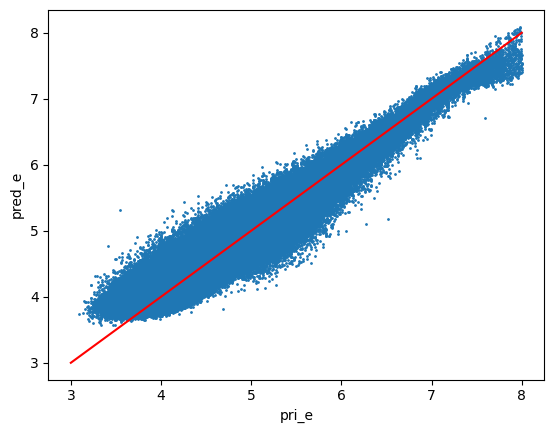

In [38]:
plt.scatter(gammadata_high_df["prie"], gammadata_high_df["prie_pred"], s=1)
plt.xlabel("pri_e")
plt.ylabel("pred_e")
plt.plot([3, 8], [3, 8], color="r")
plt.show()

In [15]:
# 使用J1857的模拟测试
J1857 = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")
# 读取为dict，每一个value为numpy格式
J1857 = J1857["asresult"].arrays(paraneed_MC_Pgamma, library="np")
# 计算模拟数据的S50
J1857["S50"] = getS50(J1857["ne"], J1857["age"])
J1857_need_high = np.where(
    (J1857["nch"] >= 16)
    & (J1857["sigma"] < 1)
    & (J1857["inout"] == 1)
    & (J1857["age"] > 0.301)
    & (J1857["age"] < 1.599)
    & ((J1857["summd"] < 0.4) | (J1857["summd"] < 1.2e-3 * J1857["sumpf"] ** 1.6))
    & (J1857["theta"] < 60)
)

J1857_high = {key: J1857[key][J1857_need_high] for key in J1857.keys()}
for para in ["ne", "S50", "sumpf", "prie"]:
    J1857_high[para] = np.log10(J1857_high[para])

In [16]:
J1857_high_df = pd.DataFrame(J1857_high)
J1857_high_df["prie_pred"] = predictor.predict(J1857_high_df)

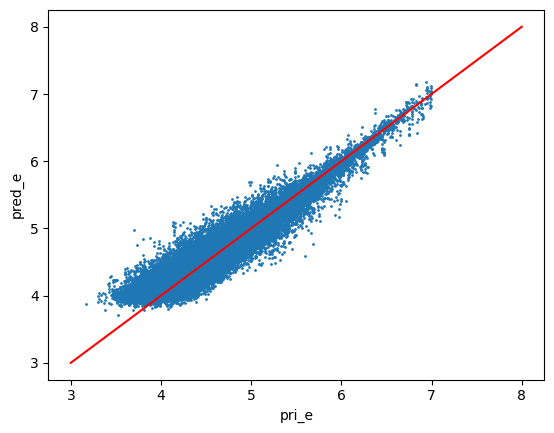

In [36]:
plt.scatter(J1857_high_df["prie"], J1857_high_df["prie_pred"], s=1)
plt.plot([3, 8], [3, 8], color="r")
plt.xlabel("pri_e")
plt.ylabel("pred_e")
plt.show()

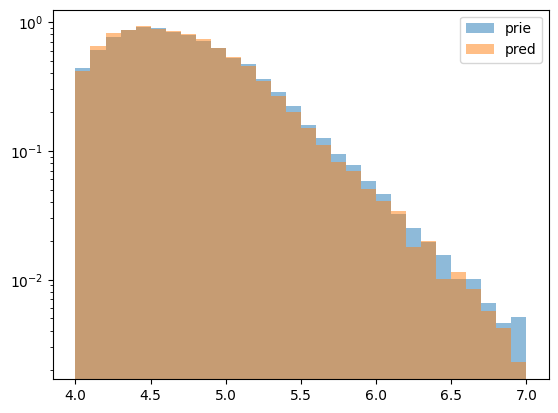

In [33]:
plt.hist(
    J1857_high_df["prie"],
    bins=np.linspace(4, 7, 31),
    alpha=0.5,
    label="prie",
    density=True,
)
plt.hist(
    J1857_high_df["prie_pred"],
    bins=np.linspace(4, 7, 31),
    alpha=0.5,
    label="pred",
    density=True,
)
plt.yscale("log")
plt.legend()
plt.show()

## 方向修正

In [40]:
gammadata_high["pritheta"] = np.rad2deg(gammadata_high["pritheta"])
gammadata_high["priphi"] = 180-np.rad2deg(gammadata_high["priphi"])
gammadata_high["priphi"][gammadata_high["priphi"] > 180] = gammadata_high["priphi"][gammadata_high["priphi"] > 180]-360

In [41]:
gammadata_high["deltatheta"] = gammadata_high["theta"]-gammadata_high["pritheta"]
gammadata_high["deltaphi"] = gammadata_high["phi"]-gammadata_high["priphi"]
gammadata_high["deltaphi"][gammadata_high["deltaphi"] <-180]+=360
gammadata_high["deltaphi"][gammadata_high["deltaphi"] >180]-=360

In [46]:
label = "deltatheta"
gammadata_high_df = pd.DataFrame(gammadata_high)
columns_need = [
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "mr1",
    "ne",
    "age",
    "S50",
]
columns_need.append(label)
predictor = TabularPredictor(
    label=label,
    path="./autogloun_model/highEnergy_deltatheta",
).fit(gammadata_high_df[columns_need], num_cpus=40, num_gpus=2)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/highEnergy_deltatheta/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    2139378
Train Data Columns: 10
Label Column: deltatheta
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (9.612025495594509, -7.147092985588266, -0.00184, 0.42056)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', '

[1000]	valid_set's rmse: 0.371177
[2000]	valid_set's rmse: 0.368006
[3000]	valid_set's rmse: 0.366813
[4000]	valid_set's rmse: 0.366076
[5000]	valid_set's rmse: 0.365489
[6000]	valid_set's rmse: 0.365094
[7000]	valid_set's rmse: 0.364849
[8000]	valid_set's rmse: 0.364648
[9000]	valid_set's rmse: 0.364409
[10000]	valid_set's rmse: 0.364304


	-0.3643	 = Validation score   (-root_mean_squared_error)
	123.79s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's rmse: 0.36845
[2000]	valid_set's rmse: 0.36702
[3000]	valid_set's rmse: 0.36645
[4000]	valid_set's rmse: 0.366134
[5000]	valid_set's rmse: 0.365814
[6000]	valid_set's rmse: 0.365692
[7000]	valid_set's rmse: 0.365645
[8000]	valid_set's rmse: 0.36588
[9000]	valid_set's rmse: 0.365735


	-0.3656	 = Validation score   (-root_mean_squared_error)
	106.76s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.3667	 = Validation score   (-root_mean_squared_error)
	245.97s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-0.3681	 = Validation score   (-root_mean_squared_error)
	19.03s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.3689	 = Validation score   (-root_mean_squared_error)
	90.94s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.3628	 = Validation score   (-root_mean_squared_error)
	652.04s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: XGBoost ...
	-0.3665	 = Validation score   (-root_mean_squared_error)
	13.28s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetTorch ..

[1000]	valid_set's rmse: 0.366537
[2000]	valid_set's rmse: 0.365345
[3000]	valid_set's rmse: 0.365099
[4000]	valid_set's rmse: 0.364779
[5000]	valid_set's rmse: 0.364754
[6000]	valid_set's rmse: 0.364517
[7000]	valid_set's rmse: 0.364609


	-0.3645	 = Validation score   (-root_mean_squared_error)
	151.71s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.3609	 = Validation score   (-root_mean_squared_error)
	0.4s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2373.95s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogloun_model/highEnergy_deltatheta/")


In [47]:
label = "deltaphi"
gammadata_high_df = pd.DataFrame(gammadata_high)
columns_need = [
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "mr1",
    "ne",
    "age",
    "S50",
]
columns_need.append(label)
predictor = TabularPredictor(
    label=label,
    path="./autogloun_model/highEnergy_deltaphi",
).fit(gammadata_high_df[columns_need], num_cpus=40, num_gpus=2)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/highEnergy_deltaphi/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    2139378
Train Data Columns: 10
Label Column: deltaphi
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (178.3685093758777, -178.77805688336724, 0.00118, 2.17283)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regr

[1000]	valid_set's rmse: 1.9617


	-1.9601	 = Validation score   (-root_mean_squared_error)
	20.98s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.
	-2.0101	 = Validation score   (-root_mean_squared_error)
	9.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2.0723	 = Validation score   (-root_mean_squared_error)
	758.18s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-2.0183	 = Validation score   (-root_mean_squared_error)
	3.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.9901	 = Validation score   (-root_mean_squared_error)
	85.87s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 0: early stopping
	-1.

[1000]	valid_set's rmse: 1.99567


	-1.9954	 = Validation score   (-root_mean_squared_error)
	30.14s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-1.8877	 = Validation score   (-root_mean_squared_error)
	0.39s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1955.08s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogloun_model/highEnergy_deltaphi/")


In [4]:
# 使用J1857的模拟测试
J1857 = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")
# 读取为dict，每一个value为numpy格式
J1857 = J1857["asresult"].arrays(paraneed_MC_Pgamma, library="np")
# 计算模拟数据的S50
J1857["S50"] = getS50(J1857["ne"], J1857["age"])
J1857_need_high = np.where(
    (J1857["nch"] >= 16)
    & (J1857["sigma"] < 1)
    & (J1857["inout"] == 1)
    & (J1857["age"] > 0.301)
    & (J1857["age"] < 1.599)
    & ((J1857["summd"] < 0.4) | (J1857["summd"] < 1.2e-3 * J1857["sumpf"] ** 1.6))
    & (J1857["theta"] < 60)
)

J1857_high = {key: J1857[key][J1857_need_high] for key in J1857.keys()}
for para in ["ne", "S50", "sumpf", "prie"]:
    J1857_high[para] = np.log10(J1857_high[para])

J1857_high["pritheta"] = np.rad2deg(J1857_high["pritheta"])
J1857_high["priphi"] = 180-np.rad2deg(J1857_high["priphi"])
J1857_high["priphi"][J1857_high["priphi"] > 180] = J1857_high["priphi"][J1857_high["priphi"] > 180]-360
J1857_high["deltatheta"] = J1857_high["theta"]-J1857_high["pritheta"]
J1857_high["deltaphi"] = J1857_high["phi"]-J1857_high["priphi"]
J1857_high["deltaphi"][J1857_high["deltaphi"] <-180]+=360
J1857_high["deltaphi"][J1857_high["deltaphi"] >180]-=360

J1857_high_df = pd.DataFrame(J1857_high)


In [5]:
predictor_deltatheta =  TabularPredictor.load("./autogloun_model/highEnergy_deltatheta/")
predictor_deltaphi =  TabularPredictor.load("./autogloun_model/highEnergy_deltaphi/")
J1857_high_df["deltatheta_pred"] = predictor_deltatheta.predict(J1857_high_df)
J1857_high_df["deltaphi_pred"] = predictor_deltaphi.predict(J1857_high_df)
J1857_high_df["pritheta_pred"] = J1857_high_df["theta"]-J1857_high_df["deltatheta_pred"]
J1857_high_df["priphi_pred"] = J1857_high_df["phi"]-J1857_high_df["deltaphi_pred"]

In [6]:
# 定义2角zhi
def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )

J1857_high_df["delta_angle"] = twoPointAngle(J1857_high_df["pritheta"],J1857_high_df["theta"],J1857_high_df["priphi"],J1857_high_df["phi"])
J1857_high_df["delta_angle_pred"] = twoPointAngle(J1857_high_df["pritheta"],J1857_high_df["pritheta_pred"],J1857_high_df["priphi"],J1857_high_df["priphi_pred"])

定义能包括一半事例的角度为角分辨。

In [7]:
np.min(J1857_high_df["sumpf"]),np.max(J1857_high_df["sumpf"])

(1.575692015414015, 4.551651244703818)

In [8]:
sumpf_bins = np.linspace(1.6,4.5,20)
Angular_resolution = np.zeros(19)
Angular_resolution_pred = np.zeros(19)

for i in range(len(sumpf_bins)-1):
    need = np.where((J1857_high_df["sumpf"]>sumpf_bins[i])&(J1857_high_df["sumpf"]<sumpf_bins[i+1]) )
    Angular_resolution[i] = np.median(J1857_high_df.loc[need,"delta_angle"])
    Angular_resolution_pred[i] = np.median(J1857_high_df.loc[need,"delta_angle_pred"])    

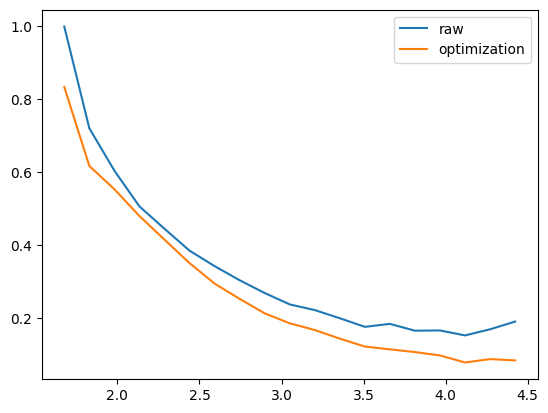

In [13]:
sumpf_bins_center = (sumpf_bins[:-1] + sumpf_bins[1:]) / 2
plt.plot(sumpf_bins_center, Angular_resolution, label="raw")
plt.plot(sumpf_bins_center, Angular_resolution_pred, label="optimization")
plt.xlabel("sumpf")
plt.ylabel("Angular resolution")
plt.legend()
plt.show()

## 低能样本

### 初步cut
第一步的cut是为了去掉过多的宇宙线事例

$nch>=4$

$sigma<=1$

$inout==1$

$summd<0.4$ 

$theta<60$

In [10]:
gammadata_need_low = np.where(
    (gammadata["nch"] >= 4)
    & (gammadata["sigma"] < 1)
    & (gammadata["inout"] == 1)
    & (gammadata["summd"] < 0.4)
    & (gammadata["theta"] < 60)
)
gammadata_low = {key: gammadata[key][gammadata_need_low] for key in gammadata.keys()}


In [11]:
# 因为这3个量跨度比较大，所以取对数
for para in ["sumpf", "prie"]:
    gammadata_low[para] = np.log10(gammadata_low[para])

## 能量拟合

In [13]:
label = "prie"
gammadata_low_df = pd.DataFrame(gammadata_low)
columns_need = [
    "theta",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "mr1",
]
columns_need.append(label)
predictor = TabularPredictor(
    label=label,
    path="./autogloun_model/lowEnergy_Energy",
).fit(gammadata_low_df[columns_need], num_cpus=40, num_gpus=2)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/lowEnergy_Energy/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    7371621
Train Data Columns: 6
Label Column: prie
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7.545938129425625, 2.477238268381866, 4.13607, 0.55636)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])


[1000]	valid_set's rmse: 0.293639
[2000]	valid_set's rmse: 0.29292
[3000]	valid_set's rmse: 0.292563
[4000]	valid_set's rmse: 0.292326
[5000]	valid_set's rmse: 0.292153
[6000]	valid_set's rmse: 0.292027
[7000]	valid_set's rmse: 0.291919
[8000]	valid_set's rmse: 0.291839
[9000]	valid_set's rmse: 0.291762
[10000]	valid_set's rmse: 0.291707


	-0.2917	 = Validation score   (-root_mean_squared_error)
	484.72s	 = Training   runtime
	2.17s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's rmse: 0.292238
[2000]	valid_set's rmse: 0.291635
[3000]	valid_set's rmse: 0.291369
[4000]	valid_set's rmse: 0.291265
[5000]	valid_set's rmse: 0.29118
[6000]	valid_set's rmse: 0.291145
[7000]	valid_set's rmse: 0.291147
[8000]	valid_set's rmse: 0.291126
[9000]	valid_set's rmse: 0.291104
[10000]	valid_set's rmse: 0.291119


	-0.2911	 = Validation score   (-root_mean_squared_error)
	358.73s	 = Training   runtime
	1.31s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.296	 = Validation score   (-root_mean_squared_error)
	687.17s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-0.2919	 = Validation score   (-root_mean_squared_error)
	57.19s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2966	 = Validation score   (-root_mean_squared_error)
	345.49s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2925	 = Validation score   (-root_mean_squared_error)
	2270.63s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2913	 = Validation score   (-root_mean_squared_error)
	44.22s	 = Training   runtime
	0.64s	 = Validation runtime
Fitting model: NeuralNetTorch 

[1000]	valid_set's rmse: 0.291521
[2000]	valid_set's rmse: 0.291275
[3000]	valid_set's rmse: 0.291164
[4000]	valid_set's rmse: 0.291135
[5000]	valid_set's rmse: 0.291111
[6000]	valid_set's rmse: 0.291148


	-0.2911	 = Validation score   (-root_mean_squared_error)
	297.35s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.2908	 = Validation score   (-root_mean_squared_error)
	0.84s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 5299.58s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogloun_model/lowEnergy_Energy/")


In [14]:
gammadata_low_df["prie_pred"] = predictor.predict(gammadata_low_df)

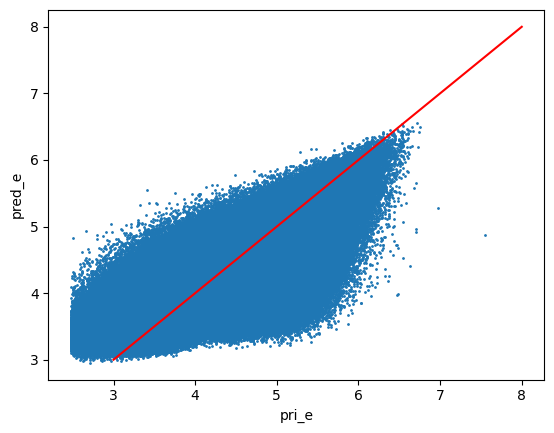

In [15]:
plt.scatter(gammadata_low_df["prie"], gammadata_low_df["prie_pred"], s=1)
plt.xlabel("pri_e")
plt.ylabel("pred_e")
plt.plot([3, 8], [3, 8], color="r")
plt.show()

In [20]:
# 使用J1857的模拟测试
J1857 = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")
# 读取为dict，每一个value为numpy格式
J1857 = J1857["asresult"].arrays(paraneed_MC_Pgamma, library="np")
# 计算模拟数据的S50
J1857["S50"] = getS50(J1857["ne"], J1857["age"])
J1857_need_low = np.where(
    (J1857["nch"] >= 4)
    & (J1857["sigma"] < 1)
    & (J1857["inout"] == 1)
    & (J1857["summd"] < 0.4)
    & (J1857["theta"] < 60)
)

J1857_low = {key: J1857[key][J1857_need_low] for key in J1857.keys()}
for para in ["sumpf", "prie"]:
    J1857_low[para] = np.log10(J1857_low[para])

In [21]:
J1857_low_df = pd.DataFrame(J1857_low)
J1857_low_df["prie_pred"] = predictor.predict(J1857_low_df)

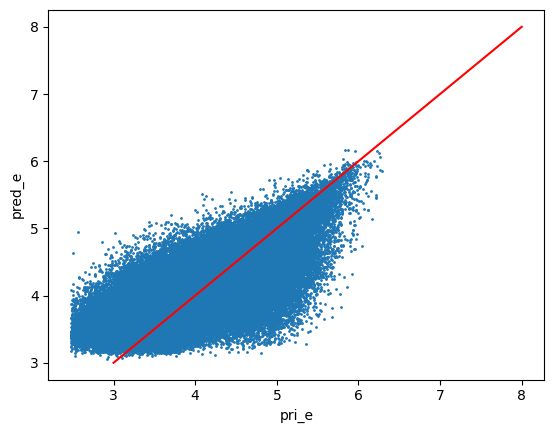

In [22]:
plt.scatter(J1857_low_df["prie"], J1857_low_df["prie_pred"], s=1)
plt.plot([3, 8], [3, 8], color="r")
plt.xlabel("pri_e")
plt.ylabel("pred_e")
plt.show()

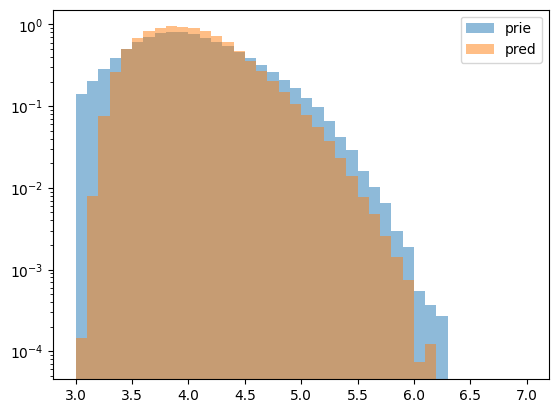

In [23]:
plt.hist(
    J1857_low_df["prie"],
    bins=np.linspace(3, 7, 41),
    alpha=0.5,
    label="prie",
    density=True,
)
plt.hist(
    J1857_low_df["prie_pred"],
    bins=np.linspace(3, 7, 41),
    alpha=0.5,
    label="pred",
    density=True,
)
plt.yscale("log")
plt.legend()
plt.show()

## 方向修正

In [24]:
gammadata_low["pritheta"] = np.rad2deg(gammadata_low["pritheta"])
gammadata_low["priphi"] = 180-np.rad2deg(gammadata_low["priphi"])
gammadata_low["priphi"][gammadata_low["priphi"] > 180] = gammadata_low["priphi"][gammadata_low["priphi"] > 180]-360

In [25]:
gammadata_low["deltatheta"] = gammadata_low["theta"]-gammadata_low["pritheta"]
gammadata_low["deltaphi"] = gammadata_low["phi"]-gammadata_low["priphi"]
gammadata_low["deltaphi"][gammadata_low["deltaphi"] <-180]+=360
gammadata_low["deltaphi"][gammadata_low["deltaphi"] >180]-=360

In [26]:
label = "deltatheta"
gammadata_low_df = pd.DataFrame(gammadata_low)
columns_need = [
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "mr1",
]
columns_need.append(label)
predictor = TabularPredictor(
    label=label,
    path="./autogloun_model/lowEnergy_deltatheta",
).fit(gammadata_low_df[columns_need], num_cpus=40, num_gpus=2)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/lowEnergy_deltatheta/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    7371621
Train Data Columns: 7
Label Column: deltatheta
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (53.72151396688687, -48.4876668671608, 0.07191, 1.82383)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regr

[1000]	valid_set's rmse: 1.7386
[2000]	valid_set's rmse: 1.73477
[3000]	valid_set's rmse: 1.73343
[4000]	valid_set's rmse: 1.73281
[5000]	valid_set's rmse: 1.73227
[6000]	valid_set's rmse: 1.73198
[7000]	valid_set's rmse: 1.73189
[8000]	valid_set's rmse: 1.73175
[9000]	valid_set's rmse: 1.73187


	-1.7317	 = Validation score   (-root_mean_squared_error)
	395.18s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's rmse: 1.73572
[2000]	valid_set's rmse: 1.73345
[3000]	valid_set's rmse: 1.7334


	-1.7332	 = Validation score   (-root_mean_squared_error)
	123.46s	 = Training   runtime
	0.34s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-1.7649	 = Validation score   (-root_mean_squared_error)
	707.47s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-1.737	 = Validation score   (-root_mean_squared_error)
	26.31s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.7777	 = Validation score   (-root_mean_squared_error)
	274.8s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 1: early stopping
	-1.7406	 = Validation score   (-root_mean_squared_error)
	1640.53s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: XGBoost ...
	-1.7357	 = Validation score   (-root_mean_squared_error)
	18.73s	 = Training   runtime
	0.1s	 = Valida

[1000]	valid_set's rmse: 1.73469


	-1.7342	 = Validation score   (-root_mean_squared_error)
	87.86s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-1.7311	 = Validation score   (-root_mean_squared_error)
	0.81s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 4588.47s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogloun_model/lowEnergy_deltatheta/")


In [27]:
label = "deltaphi"
gammadata_low_df = pd.DataFrame(gammadata_low)
columns_need = [
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "mr1",

]
columns_need.append(label)
predictor = TabularPredictor(
    label=label,
    path="./autogloun_model/lowEnergy_deltaphi",
).fit(gammadata_low_df[columns_need], num_cpus=40, num_gpus=2)

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogloun_model/lowEnergy_deltaphi/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.179-1 (2023-05-12)
Train Data Rows:    7371621
Train Data Columns: 7
Label Column: deltaphi
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (179.96050531002444, -179.95248118241756, 0.00081, 7.61418)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regre

[1000]	valid_set's rmse: 7.27519
[2000]	valid_set's rmse: 7.26877
[3000]	valid_set's rmse: 7.26828


	-7.2677	 = Validation score   (-root_mean_squared_error)
	144.05s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.
	-7.3162	 = Validation score   (-root_mean_squared_error)
	46.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-7.4173	 = Validation score   (-root_mean_squared_error)
	3236.94s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-7.3046	 = Validation score   (-root_mean_squared_error)
	21.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-7.3513	 = Validation score   (-root_mean_squared_error)
	225.3s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-7.3041	 = Validation score   (-root_mea

In [28]:
# 使用J1857的模拟测试
J1857 = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")
# 读取为dict，每一个value为numpy格式
J1857 = J1857["asresult"].arrays(paraneed_MC_Pgamma, library="np")
# 计算模拟数据的S50
J1857["S50"] = getS50(J1857["ne"], J1857["age"])
J1857_need_low = np.where(
    (J1857["nch"] >= 4)
    & (J1857["sigma"] < 1)
    & (J1857["inout"] == 1)
    & (J1857["summd"] < 0.4)
    & (J1857["theta"] < 60)
)

J1857_low = {key: J1857[key][J1857_need_low] for key in J1857.keys()}
for para in ["sumpf", "prie"]:
    J1857_low[para] = np.log10(J1857_low[para])

J1857_low["pritheta"] = np.rad2deg(J1857_low["pritheta"])
J1857_low["priphi"] = 180-np.rad2deg(J1857_low["priphi"])
J1857_low["priphi"][J1857_low["priphi"] > 180] = J1857_low["priphi"][J1857_low["priphi"] > 180]-360
J1857_low["deltatheta"] = J1857_low["theta"]-J1857_low["pritheta"]
J1857_low["deltaphi"] = J1857_low["phi"]-J1857_low["priphi"]
J1857_low["deltaphi"][J1857_low["deltaphi"] <-180]+=360
J1857_low["deltaphi"][J1857_low["deltaphi"] >180]-=360

J1857_low_df = pd.DataFrame(J1857_low)


In [30]:
predictor_deltatheta =  TabularPredictor.load("./autogloun_model/lowEnergy_deltatheta/")
predictor_deltaphi =  TabularPredictor.load("./autogloun_model/lowEnergy_deltaphi/")
J1857_low_df["deltatheta_pred"] = predictor_deltatheta.predict(J1857_low_df)
J1857_low_df["deltaphi_pred"] = predictor_deltaphi.predict(J1857_low_df)
J1857_low_df["pritheta_pred"] = J1857_low_df["theta"]-J1857_low_df["deltatheta_pred"]
J1857_low_df["priphi_pred"] = J1857_low_df["phi"]-J1857_low_df["deltaphi_pred"]

In [31]:
# 定义2角zhi
def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )

J1857_low_df["delta_angle"] = twoPointAngle(J1857_low_df["pritheta"],J1857_low_df["theta"],J1857_low_df["priphi"],J1857_low_df["phi"])
J1857_low_df["delta_angle_pred"] = twoPointAngle(J1857_low_df["pritheta"],J1857_low_df["pritheta_pred"],J1857_low_df["priphi"],J1857_low_df["priphi_pred"])

定义能包括一半事例的角度为角分辨。

In [32]:
np.min(J1857_low_df["sumpf"]),np.max(J1857_low_df["sumpf"])

(0.8397162294092448, 3.7687340997181185)

In [38]:
sumpf_bins = np.linspace(0.8,3.8,16)
Angular_resolution = np.zeros(15)
Angular_resolution_pred = np.zeros(15)

for i in range(len(sumpf_bins)-1):
    need = np.where((J1857_low_df["sumpf"]>sumpf_bins[i])&(J1857_low_df["sumpf"]<sumpf_bins[i+1]) )
    Angular_resolution[i] = np.median(J1857_low_df.loc[need,"delta_angle"])
    Angular_resolution_pred[i] = np.median(J1857_low_df.loc[need,"delta_angle_pred"])    

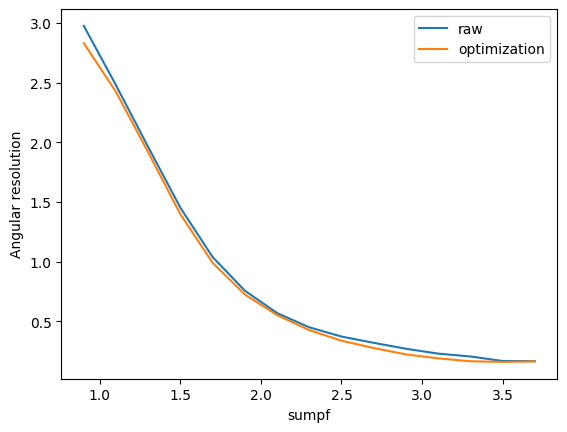

In [39]:
sumpf_bins_center = (sumpf_bins[:-1] + sumpf_bins[1:]) / 2
plt.plot(sumpf_bins_center, Angular_resolution, label="raw")
plt.plot(sumpf_bins_center, Angular_resolution_pred, label="optimization")
plt.xlabel("sumpf")
plt.ylabel("Angular resolution")
plt.legend()
plt.show()